In [1]:
import networkx as nx
import random
import community as community_louvain
import pandas as pd
from collections import Counter


import matplotlib.pyplot as plt

In [ ]:
def calculate_edge_counts(G_sub, A_nodes, B_nodes):
    """
    Calculate edge counts from B_nodes to A_nodes for the subgraph G_sub.

    Parameters:
    - G_sub: NetworkX graph (subgraph)
    - A_nodes: List of nodes in group A
    - B_nodes: List of nodes in group B

    Returns:
    - edges_from_B_to_A_df: DataFrame with edge counts from B_nodes to A_nodes
    - binary_edge_count_df: Binary DataFrame indicating if edge count > 0
    - edge_count_refined_df: DataFrame with counts of edge contributions from each node in B_nodes
    """
    # Filter A_nodes and B_nodes to only include valid nodes
    valid_A_nodes = [a for a in A_nodes if a in G_sub.nodes]
    valid_B_nodes = [b for b in B_nodes if b in G_sub.nodes]

    # Calculate the number of edges from B_nodes to each A_node
    edges_from_B_to_A = {a: sum(G_sub.number_of_edges(b, a) for b in valid_B_nodes) for a in valid_A_nodes}

    # Add missing nodes with edge count 0
    for a in A_nodes:
        if a not in edges_from_B_to_A:
            edges_from_B_to_A[a] = 0

    edges_from_B_to_A_df = pd.DataFrame.from_dict(edges_from_B_to_A, orient='index', columns=['Edge Count'])

    # Create a binary DataFrame for edge counts
    binary_edge_count_df = pd.DataFrame(0, index=A_nodes, columns=range(max(edges_from_B_to_A.values()) + 1))

    # Fill the DataFrame with binary indicators
    for node, count in edges_from_B_to_A.items():
        binary_edge_count_df.loc[node, count] = 1

    # Adjusted portion for edge_count_refined_df
    # Initialize the DataFrame with zeros
    edge_count_refined_df = pd.DataFrame(0, index=A_nodes, columns=range(1, len(valid_B_nodes) + 1))

    # Iterate through each node in A
    for a in valid_A_nodes:
        # Count the number of edges from each node in B to the current node in A
        edge_counts = [G_sub.number_of_edges(b, a) for b in valid_B_nodes]

        # Count the frequency of how many nodes in B have a specific edge count
        edge_count_freq = Counter(edge_counts)

        # Update the DataFrame
        for edge_count, count_of_nodes in edge_count_freq.items():
            if edge_count != 0:  # Skip edge_count = 0
                edge_count_refined_df.loc[a, edge_count] = count_of_nodes

    # Remove columns that contain only zeros
    edge_count_refined_df = edge_count_refined_df.loc[:, (edge_count_refined_df != 0).any(axis=0)]

    # Remove the column named 0 from binary_edge_count_df
    binary_edge_count_df.drop(columns=[0], inplace=True)

    return edges_from_B_to_A_df, binary_edge_count_df, edge_count_refined_df


Test data generated

In [31]:
# 1. Generate a random directed network with 20 nodes
num_nodes = 20
G = nx.MultiDiGraph()

G.add_nodes_from(range(num_nodes))

# Add random edges with some probability
edge_prob = 0.2
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:
            if random.random() < edge_prob:
                G.add_edge(i, j)

# 2. Apply Louvain on the graph
G_und = G.to_undirected()
partition = community_louvain.best_partition(G_und)
# Identify unique community ids
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

# Pick the two biggest communities and call them A_nodes and B_nodes
sorted_communities = sorted(communities.values(), key=len, reverse=True)
A_nodes = sorted_communities[0]
B_nodes = sorted_communities[1]

A_nodes = sorted(A_nodes)
B_nodes = sorted(B_nodes)

print("A_nodes:", A_nodes)
print("B_nodes:", B_nodes)



A_nodes: [0, 1, 2, 3, 5, 6, 7, 9, 14]
B_nodes: [8, 10, 16, 17, 19]


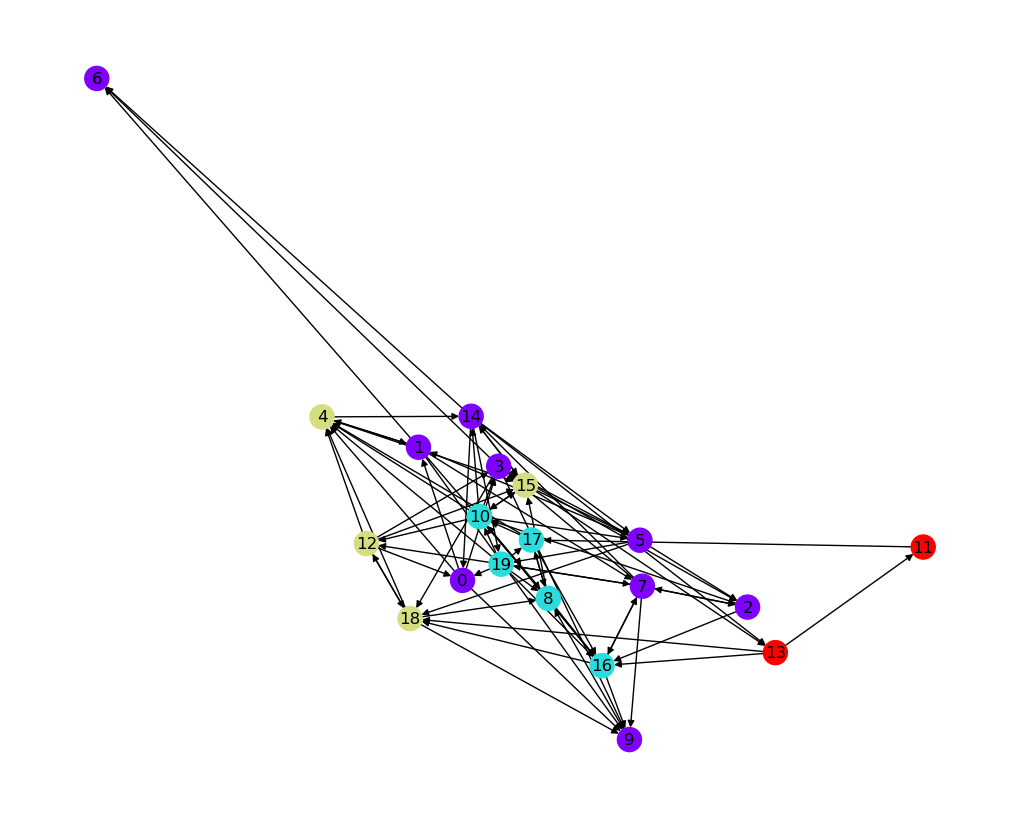

In [32]:
# Create a color map based on the partition
colors = [partition[node] for node in G.nodes()]

# Draw the graph with node colors based on community
plt.figure(figsize=(10, 8))
nx.draw(G, node_color=colors, with_labels=True, cmap=plt.cm.rainbow)
plt.show()

In [27]:
G.add_edge(13, 19)
G.add_edge(14, 19)
#G.remove_edge(0, 18)

0

calculate edge counts df returns 3 dfs:
1. edge_sum_from_A_to_B_df: total sum to incomming edges for each node in A
2. binary_edge_count_df: same information but binary matrix where columns are edge counts 
3. edge_count_refined_df: columns are edge counts, but it counts how many edges come from each node in B. suppose there are 2 edges coming into a from b and c (b,c, in B) it will have 2 in column 2 (so that the total count for double edges is 2*2) - just another way to organize the edge count

In [ ]:
#get subgraph for A_nodes and B_nodes
G_sub = G.subgraph(A_nodes + B_nodes)

# Calculate 3 edge count dfs
edge_sum_from_B_to_A_df, binary_edge_count_df, edge_count_refined_df = calculate_edge_counts(G_sub, A_nodes, B_nodes)


Another test data - 200 nodes

In [14]:
# Import colors and graph
file_path = '/home/aya/alzh_genes_fibers/scripts/Bryants_repair/data/200_nodes/200_nodes.colors.txt'
df_colors = pd.read_csv(file_path, sep='\t', header=None, names=['Node', 'Cluster'])
file_path_graph = '/home/aya/alzh_genes_fibers/scripts/Bryants_repair/data/200_nodes/200_nodes.graph.txt'
Digraph = nx.read_edgelist(file_path_graph, create_using=nx.DiGraph(), data=(('weight', float),))

# Group nodes by their cluster
communities = df_colors.groupby('Cluster')['Node'].apply(list).values

# Sort the communities by their size in descending order
sorted_communities = sorted(communities, key=len, reverse=True)

# Pick the two biggest communities and call them A_nodes and B_nodes
A200_nodes = sorted_communities[0]
B200_nodes = sorted_communities[1]

G_200_sub = Digraph.subgraph(A200_nodes + B200_nodes)

In [ ]:
edge_sum_from_B_to_A_200df, binary_edge_count_200df, edge_count_refined_200df = calculate_edge_counts(G_200_sub, A200_nodes, B200_nodes)

# 2. Lattice (no go yet)

In [41]:
def attribute_closure(df, attrs):
    """
    Given a subset of attributes 'attrs', compute the formal concept closure:
    - Find the set of objects (extent) that have all attributes in 'attrs' = 1.
    - Then find all attributes (intent) that are common (value = 1) to all these objects.
    """
    if len(attrs) == 0:
        # If no attributes are specified, the extent is all objects
        extent = set(df.index)
    else:
        # Extent: all objects for which all attributes in attrs are 1
        mask = (df[list(attrs)] == 1).all(axis=1)
        extent = set(df.index[mask])
    
    # Intent: attributes that are 1 for all objects in the extent
    if len(extent) == 0:
        # If no objects match, no attributes are forced
        intent = set()
    else:
        sub_df = df.loc[list(extent)]
        # Attributes that are 1 for every object in the extent
        intent = set(sub_df.columns[(sub_df == 1).all(axis=0)])
    
    return extent, intent

def next_closure(df, prev_intent, attrs, all_concepts):
    for i in reversed(range(len(attrs))):
        attr = attrs[i]
        if attr not in prev_intent:
            candidate_intent = (set(a for a in prev_intent if a in attrs[:i])) | {attr}
            extent, intent = attribute_closure(df, candidate_intent)

            # Debugging: Print candidate and intent
            print(f"Candidate Intent: {candidate_intent}, Closure Intent: {intent}")

            if all_concepts is not None and any(con[1] == intent for con in all_concepts):
                continue
            
            sorted_intent = sorted(list(intent), key=lambda x: attrs.index(x))
            sorted_prev = sorted(list(prev_intent), key=lambda x: attrs.index(x))

            # Debugging: Print comparison results
            print(f"Comparing {sorted_intent} >= {sorted_prev}")

            if (len(sorted_intent) > len(sorted_prev)) or \
               (len(sorted_intent) == len(sorted_prev) and all(x >= y for x, y in zip(sorted_intent, sorted_prev))):
                print(f"New Concept Found: Extent={extent}, Intent={intent}")
                all_concepts.append((extent, intent))
                next_closure(df, intent, attrs, all_concepts)
    return

# Example usage:
# Assuming 'concept_table_refined_df' is the DataFrame with columns like count_0, count_1, ..., total_2, total_4, etc.
# Rows represent nodes in A, columns represent partial counts and totals, values are integers (0 or more for counts, 0/1 for totals).

# Sort attributes for a stable order
all_attributes = list(edge_count_refined_df.columns)

# Compute the first concept from the empty set of attributes
empty_extent, empty_intent = attribute_closure(edge_count_refined_df, set())
all_concepts = [(empty_extent, empty_intent)]

# Enumerate all concepts using next_closure
next_closure(edge_count_refined_df, empty_intent, all_attributes, all_concepts)

# Print the found concepts
print("Found Concepts:")
for extent, intent in all_concepts:
    print("Extent (Objects):", extent, "Intent (Attributes):", intent)


Candidate Intent: {2}, Closure Intent: {2}
Comparing [2] >= []
New Concept Found: Extent={18, 6}, Intent={2}
Candidate Intent: {1}, Closure Intent: {1}
Comparing [1] >= [2]
Candidate Intent: {1}, Closure Intent: {1}
Comparing [1] >= []
New Concept Found: Extent={17, 15}, Intent={1}
Candidate Intent: {1, 2}, Closure Intent: set()
Found Concepts:
Extent (Objects): {2, 5, 6, 8, 9, 15, 16, 17, 18} Intent (Attributes): set()
Extent (Objects): {18, 6} Intent (Attributes): {2}
Extent (Objects): {17, 15} Intent (Attributes): {1}


In [53]:


def next_closure(df, prev_intent, attrs, all_concepts):
    """
    Compute the next closure in the NextClosure algorithm (Ganter's).
    df: binary context as a DataFrame
    prev_intent: previously found intent (set of attributes)
    attrs: sorted list of all attributes
    all_concepts: list of (extent, intent) pairs (formal concepts)
    """
    # Iterate attributes in reverse order to find the next closure
    for i in reversed(range(len(attrs))):
        attr = attrs[i]
        if attr not in prev_intent:
            # Candidate intent: add attr to a subset of prev_intent (those attrs before i)
            candidate_intent = (set(a for a in prev_intent if a in attrs[:i])) | {attr}
            
            # Compute closure of the candidate intent
            extent, intent = attribute_closure(df, candidate_intent)
            
            # Debug: Check candidate intent and closure
            print(f"Candidate Intent: {candidate_intent}, Closure Intent: {intent}")
            
            # Check if this concept is new
            if any(con[1] == intent for con in all_concepts):
                continue
            
            sorted_intent = sorted(list(intent), key=lambda x: attrs.index(x))
            sorted_prev = sorted(list(prev_intent), key=lambda x: attrs.index(x))
            
            # Debug: Check lexicographic comparison
            print(f"Comparing {sorted_intent} >= {sorted_prev}")
            
            # Check lexicographic order
            if (len(sorted_intent) > len(sorted_prev)) or \
               (len(sorted_intent) == len(sorted_prev) and all(x >= y for x, y in zip(sorted_intent, sorted_prev))):
                # Found a new concept
                print(f"New Concept Found: Extent={extent}, Intent={intent}")
                all_concepts.append((extent, intent))
                # Recursively find next concepts from this new intent
                next_closure(df, intent, attrs, all_concepts)
    return

def attribute_closure(df, attrs):
    """
    Given a subset of attributes 'attrs', compute the formal concept closure:
    - Find the set of objects (extent) that have all attributes in 'attrs' = 1.
    - Then find all attributes (intent) that are common (value = 1) to all these objects.
    """
    # Debug: Print current attributes being processed
    print(f"Current attributes being processed: {attrs}")

    # Ensure attrs is a subset of DataFrame columns
    if not set(attrs).issubset(df.columns):
        raise KeyError(f"Attributes {attrs} are not valid columns in the DataFrame.")

    if len(attrs) == 0:
        # If no attributes are specified, the extent is all objects
        extent = set(df.index)
    else:
        # Extent: all objects for which all attributes in attrs are 1
        mask = (df[list(attrs)] == 1).all(axis=1)
        extent = set(df.index[mask])
    
    # Debug: Check extent computation
    print(f"Extent for attributes {attrs}: {extent}")
    
    # Intent: attributes that are 1 for all objects in the extent
    if len(extent) == 0:
        # If no objects match, no attributes are forced
        intent = set()
        sub_df = None  # No sub_df because extent is empty
    else:
        sub_df = df.loc[list(extent)]
        # Attributes that are 1 for every object in the extent
        intent = set(sub_df.columns[(sub_df == 1).all(axis=0)])
    
    # Debug: Check intent computation
    if sub_df is not None:
        print(f"Sub-DataFrame for extent {extent}:\n{sub_df}")
    print(f"Intent: {intent}")
    
    return extent, intent

df = edge_count_refined_df

# Step 1: Sort attributes for a stable order
all_attributes = list(df.columns)

# Step 2: Compute the first concept (empty attributes)
empty_extent, empty_intent = attribute_closure(df, set())

# Step 3: Initialize the concepts list with the first concept
all_concepts = [(empty_extent, empty_intent)]

# Step 4: Run the NextClosure algorithm to find all concepts
next_closure(df, empty_intent, all_attributes, all_concepts)

# Step 5: Print all concepts
print("\nFound Concepts:")
for extent, intent in all_concepts:
    print(f"Extent (Objects): {extent}, Intent (Attributes): {intent}")



Current attributes being processed: set()
Extent for attributes set(): {2, 5, 6, 8, 9, 15, 16, 17, 18}
Sub-DataFrame for extent {2, 5, 6, 8, 9, 15, 16, 17, 18}:
    1  2
2   0  0
5   0  0
6   0  1
8   0  0
9   0  0
15  1  0
16  0  0
17  1  0
18  2  1
Intent: set()
Current attributes being processed: {2}
Extent for attributes {2}: {18, 6}
Sub-DataFrame for extent {18, 6}:
    1  2
18  2  1
6   0  1
Intent: {2}
Candidate Intent: {2}, Closure Intent: {2}
Comparing [2] >= []
New Concept Found: Extent={18, 6}, Intent={2}
Current attributes being processed: {1}
Extent for attributes {1}: {17, 15}
Sub-DataFrame for extent {17, 15}:
    1  2
17  1  0
15  1  0
Intent: {1}
Candidate Intent: {1}, Closure Intent: {1}
Comparing [1] >= [2]
Current attributes being processed: {1}
Extent for attributes {1}: {17, 15}
Sub-DataFrame for extent {17, 15}:
    1  2
17  1  0
15  1  0
Intent: {1}
Candidate Intent: {1}, Closure Intent: {1}
Comparing [1] >= []
New Concept Found: Extent={17, 15}, Intent={1}
Curr

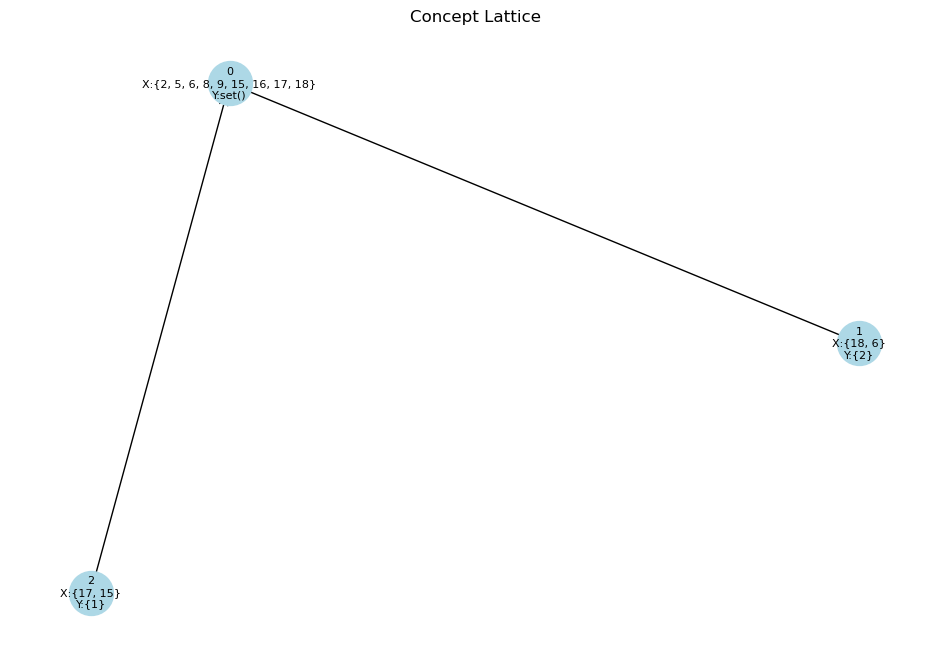

In [54]:
# Assuming all_concepts is a list of (extent, intent) pairs returned by Ganter’s algorithm
# Each extent/intent is a Python set
# Example: all_concepts = [ (set_of_objects, set_of_attributes), ... ]

def create_concept_lattice(all_concepts):
    # Create a graph to represent the lattice
    lattice = nx.DiGraph()

    # Assign an ID to each concept for easy handling
    concept_ids = {frozenset(c[0]): i for i, c in enumerate(all_concepts)}
    for c in all_concepts:
        lattice.add_node(concept_ids[frozenset(c[0])], extent=c[0], intent=c[1])

    # Function to check if c1 < c2 in the concept order
    def concept_less_equal(c1, c2):
        X1, Y1 = c1
        X2, Y2 = c2
        # c1 <= c2 if X1 is subset of X2 (or equivalently Y2 subset of Y1)
        return X1.issubset(X2)

    # Add edges for covering relations only
    # A covering relation means there is no other concept strictly between c1 and c2
    for c1 in all_concepts:
        for c2 in all_concepts:
            if c1 != c2 and concept_less_equal(c1, c2):
                # Check minimality (cover): no c3 exists with c1 < c3 < c2
                # If minimal, add edge c1 -> c2
                is_cover = True
                for c3 in all_concepts:
                    if c3 not in (c1, c2):
                        if concept_less_equal(c1, c3) and concept_less_equal(c3, c2) and c3 != c1 and c3 != c2:
                            is_cover = False
                            break
                if is_cover:
                    lattice.add_edge(concept_ids[frozenset(c1[0])], concept_ids[frozenset(c2[0])])
    
    return lattice, concept_ids

# Create the concept lattice
lattice, concept_ids = create_concept_lattice(all_concepts)

# Draw the lattice
pos = nx.spring_layout(lattice, seed=42)  # Layout can be changed
plt.figure(figsize=(12,8))
nx.draw_networkx_nodes(lattice, pos, node_color='lightblue', node_size=1000)
nx.draw_networkx_edges(lattice, pos, arrowstyle='->', arrowsize=15)
nx.draw_networkx_labels(lattice, pos, {concept_ids[frozenset(c[0])]: f"{concept_ids[frozenset(c[0])]}\nX:{c[0]}\nY:{c[1]}" for c in all_concepts}, font_size=8)

plt.title("Concept Lattice")
plt.axis('off')
plt.show()


In [ ]:
# Group nodes by their cluster
communities = df_colors.groupby('Cluster')['Node'].apply(list).values

# Sort the communities by their size in descending order
sorted_communities = sorted(communities, key=len, reverse=True)

# Pick the two biggest communities and call them A_nodes and B_nodes
A_nodes = sorted_communities[0]
B_nodes = sorted_communities[1]


In [ ]:
# Compute the concept table for the largest two parts of the partition
concept_table_df, unique_totals = compute_concept_table(A_nodes, B_nodes, G)

# Print results
print("Unique Totals (Columns):", unique_totals)
print("Concept Table (rows = A_nodes, columns = totals):")
print(concept_table_df)